## BAND Framework Toy Model: Ball Drop

### Part 1: Emulation

This is Alan's version of [Surmise's Example 1](https://nbviewer.jupyter.org/github/surmising/surmise/blob/master/examples/Example1/Example1_nb.ipynb). In this example, we will emulate the results from two different **Ball Drop models**: turning on and off the drag force (quadratic velocity dependence). 

First, we import the required libraries

In [1]:
import numpy as np 
import scipy.stats as sps
import matplotlib.pyplot as plt
import math

from emulation import emulator

### Models

The height of a large falling ball from a tower is recorded at different times until it reaches the ground. The same phenomenon is described by two different models.


#### Model 1 ($M_{1}$)

We describe the falling ball without drag force. Here, the gravitational force causes the object to have acceleration $g$ downward. The height is given by *$h = h_{0} - \frac{1}{2}gt^{2}$* where $h_{0}$ is the initial height and $t$ is the time to reach $h$. The inputs used are:

- time $t$,
- initial height $h_{0}$, and
- gravity $g$.

For the next function, we use $x = (t, h_{0})$ and $\theta = g$; $f$ represents the model outputs.

In [2]:
#x and theta are arrays. 

def balldropmodel_grav(x, theta):
    f = np.zeros((theta.shape[0],x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1]
        g = theta[k]
        f[k, :] = h0 - (g / 2) * (t ** 2)
    return f.T

In [3]:
#Checking outputs, and how to arrange inputs:

#x = np.array([[1,10],[1,40], [1,8]])
#theta = np.array([9.8, 10])
#h = balldropmodel_grav(x, theta)
#print(h)

### Model 2 ($M_{2}$)

$M_{2}$ here is different from that in [surmise](https://nbviewer.jupyter.org/github/surmising/surmise/blob/master/examples/Example1/Example1_nb.ipynb). Surmise uses a drag force that is linear with the velocity. Here, we'll use the quadratic drag force of ball drop in accordance with the [BAND Manifesto](https://arxiv.org/abs/2012.07704).

We will use the following inputs:

- time $t$,
- drag coefficient $\gamma$,
- gravity $g$,
- ball's diameter $D$,
- ball's mass $m$, and 
- initial height $h_{0}$.

Here $x = (t, h_{0})$ and $\theta = (g, \gamma)$, and $\phi$ = ($m, D$); $f$ represents the model outputs. 

${\bf Note: }$ Separate m and D from $\theta$ array.

In [4]:
def balldropmodel_quad(x, theta, phi):
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1]
        g = theta[k, 0]
        gamma = theta[:, 1]
        m = phi[:, 0]
        D = phi[:, 1]
        c = gamma[k]*(D[k]**2)
        vter = np.sqrt(m[k] * (g/c))
        
        if gamma[k] > 0.0 :
            f[k, :] = h0 - ((vter**2)/g)*np.log(np.cosh(g*t/vter))
        else :
            f[k, :] = balldropmodel_grav(x, theta)
    return f.T

In [5]:
#Playing around, checking outputs, and how to arrange inputs:

# x = np.array([[1,10],[1,40]])
# theta = np.array([[5, 9.8, 0.002], [5, 9.8, 0.001]])
# param = np.array([[1,1],[1,1]])
# h = balldropmodel_quad(x, theta, param)
# print(h)

#M2 works and agrees with M1 in the limit gamma -> 0.

Let me now implement the previous models in the same input space that Surmise uses. i.e. on an input grid $t \in [0.1,4.2]$ and $h_{0} \in \{25,50\}$.

In [6]:
# the time vector of interest
tvec = np.concatenate((np.arange(0.1, 4.3, 0.1), np.arange(0.1, 4.3, 0.1)))

# the drop heights vector of interest
h0vec = np.concatenate((25 * np.ones(42), 50 * np.ones(42)))  

# the input of interest
xtot = (np.vstack((tvec, h0vec)).T).astype('object')


xtotv = xtot.astype('float')
xtot[xtot[:,1] == 25, 1] = 'lowdrop'
xtot[xtot[:,1] == 50, 1] = 'highdrop'

print(np.shape(xtot))

(84, 2)


In [7]:
# Printing and checking

#print(tvec)
#print(xtot)

### Prior specification

Researchers have a prior knowledge about the unknown parameters in the form of a prior distribution.

In $M_{1}$, we assume 

- $g$ is gamma-distributed random variable with shape $\alpha$, location $\mu$ and rate $\beta$ parameters such that $g$ $\sim$ $\Gamma (\alpha,\mu,\beta)$ with $\alpha$ = 2, $\mu$ = 0, $\beta$ = 4.9. This gives a mean $\alpha * \beta$ = $9.8$. 

In $M_{2}$, we assume 

-  $g$ has a gamma distribution with shape $\alpha$, location $\mu$ and rate $\beta$ parameters such that $g$ $\sim$ $\Gamma (\alpha,\mu,\beta)$ with \$\alpha$ = 2, $\mu$ = 0, $\beta$ = 4.9. This gives mean $\alpha * \beta$ = $9.8$.


-  $\gamma$ has a gamma distribution with shape $\alpha$, location $\mu$ and rate $\beta$ parameters such that $\gamma$ $\sim$ $\Gamma (\alpha,\mu,\beta)$ with $\alpha$ = 10, $\mu$ = 0, $\beta$ = 0.05. This gives mean $\alpha * \beta$ = $0.5$ and its narrow enough for the majority of the pdf to be in $[0.3, 0.7]$. Variance is given by $\alpha * \beta^{2}$.

In [8]:
class priorphys_grav:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        return (sps.gamma.logpdf(theta[:, 0], 2, 0, 4.9)).reshape((len(theta), 1))
    
    def rnd(n):
        return np.reshape(sps.gamma.rvs(2, 0, 4.9, size=n), (-1, 1))  # gravity

In [9]:
class priorphys_quad:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        return (sps.gamma.logpdf(theta[:, 0], 2, 0, 4.9), #gravity
                sps.gamma.logpdf(theta[:, 1], 10, 0, 0.05)).reshape((len(theta), 1))   # gamma


    def rnd(n):
        return np.vstack((sps.gamma.rvs(2, 0, 4.9, size=n),  # gravity
                          sps.gamma.rvs(10, 0, 0.05, size=n))).T # gamma

In [10]:
#Setting things to plot the distribitions

def dist_stuff(dist):
    """
    Finds the median, mean, and 68%/95% credible intervals for the given 
    1-d distribution (which is an object from scipy.stats).  
    """
    # For x = median, mean: return x and the value of the pdf at x as a list
    median = [dist.median(), dist.pdf(dist.median())]  
    mean = [dist.mean(), dist.pdf(dist.mean())]
    # The left and right limits of the credibility interval are returned
    cred68 = dist.interval(0.68)
    cred95 = dist.interval(0.95)
    return median, mean, cred68, cred95

def dist_mode(dist, x):
    """
    Return the mode (maximum) of the 1-d distribution for array x.
    """
    x_max_index = dist.pdf(x).argmax()
    # Return x of the maximum and the value of the pdf at that x 
    mode = [x[x_max_index], dist.pdf(x[x_max_index])]
    return mode

def dist_plot(ax, dist_label, x_dist, dist, color='blue'):
    """
    Plot the distribution, indicating median, mean, mode
    and 68%/95% probability intervals on the axis that is passed.
    """
    median, mean, cred68, cred95 = dist_stuff(dist)
    mode = dist_mode(dist, x_dist)
    
    ax.plot(x_dist, dist.pdf(x_dist), label=dist_label, color=color)    
    ax.set_xlabel('x')
    ax.set_ylabel('p(x)')
    
    # Point to the median, mode, and mean with arrows (adjusting the spacing)
    text_x = 0.2*(x_dist[-1] - x_dist[0])
    text_x_mid = (x_dist[-1] + x_dist[0]) / 2.
    text_y = mode[1]*1.15
    ax.annotate('median', xy=median, xytext=(text_x_mid+text_x, text_y),
                arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('mode', xy=mode, xytext=(text_x_mid-text_x, text_y),
                arrowprops=dict(facecolor='red', shrink=0.05))
    ax.annotate('mean', xy=mean, xytext=(text_x_mid, text_y),
                arrowprops=dict(facecolor='blue', shrink=0.05))
    
    # Mark the credible intervals using shading (with appropriate alpha)
    ax.fill_between(x_dist, 0, dist.pdf(x_dist), 
                    where=((x_dist > cred68[0]) & (x_dist < cred68[1])), 
                    facecolor='blue', alpha=0.2)
    ax.fill_between(x_dist, 0, dist.pdf(x_dist), 
                    where=((x_dist > cred95[0]) & (x_dist < cred95[1])), 
                    facecolor='blue', alpha=0.1)
    
    ax.legend();

Gamma distribution mean:  3.0 
Gamma distribution median:  2.517520485024992


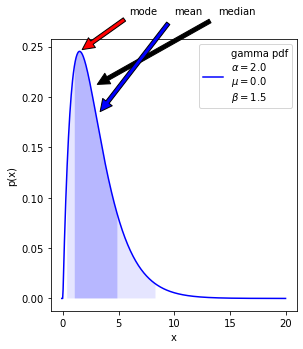

In [25]:
# Make some standard plots: normal, gamma
fig = plt.figure(figsize=(15,5))
    
# gamma distribution, characterized by a, m, and b parameters
x_gamma = np.linspace(-0.1, 20, 500)  # beta ranges from 0 to 1 
a = 2
m = 0
b = 1.5

gamma_dist = sps.gamma(a, m, b)  # the gamma distribution from scipy.stats
gamma1_label='gamma pdf' + '\n' + rf'$\alpha=${a:1.1f}' \
              + '\n' + rf'$\mu=${m:1.1f}' \
              + '\n' + rf'$\beta=${b:1.1f}'
ax2 = fig.add_subplot(1,3,2)
dist_plot(ax2, gamma1_label, x_gamma, gamma_dist)

print("Gamma distribution mean: ", gamma_dist.mean(), \
      "\nGamma distribution median: ", gamma_dist.median())

Normal distribution mean:  0.0 
Normal distribution median:  0.0


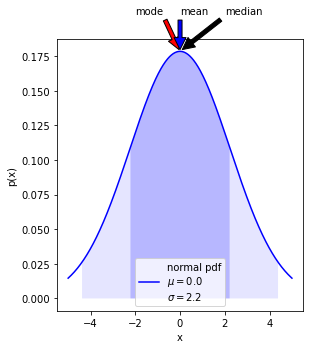

In [12]:
# Make some standard plots: normal, gamma
fig2 = plt.figure(figsize=(15,5))

# Standard normal distribution -- try changing the mean and std. dev. 
x_norm = np.linspace(-5, 5, 500)
mu = 0       # mean
sigma = math.sqrt(5)  # standard deviation
norm_dist = sps.norm(mu, sigma) # the normal distribution from scipy.stats
norm_label='normal pdf' + '\n' + rf'$\mu=${mu:1.1f}' \
             + '\n' + rf'$\sigma=${sigma:1.1f}' 
ax1 = fig2.add_subplot(1,3,1)
dist_plot(ax1, norm_label, x_norm, norm_dist)

print("Normal distribution mean: ", norm_dist.mean(), \
      "\nNormal distribution median: ", norm_dist.median())

Now, we draw 50 random parameters.

In [13]:
# draw 50 random parameters from the prior
theta_grav = priorphys_grav.rnd(50) 
print(np.shape(theta_grav))

# draw 50 random parameters from the prior
theta_quad = priorphys_quad.rnd(50)
print(np.shape(theta_quad))

# Specify mass and diameter of the ball. Draw a list of fixed parameters
m = 1
D = 1
phi = np.vstack(( m * np.ones(50), D * np.ones(50))).T

(50, 1)
(50, 2)


In [14]:
# Printing and checking

#print(theta_grav)
#print(theta_quad)
#print(phi)

Let's evaluate the computer models $M_{1}$ and $M_{2}$ at those random points generated above.

In [15]:
# create a computer experiment to build an emulator for the gravity simulation
f_grav = balldropmodel_grav(xtotv, theta_grav)  
print(np.shape(f_grav))

# create a computer experiment to build an emulator for the quadratic simulation
f_quad = balldropmodel_quad(xtotv, theta_quad, phi) 
print(np.shape(f_quad))

(84, 50)
(84, 50)


In [16]:
# Printing and checking

#print("\n First: \n \n", f_grav)
#print("\n Second: \n \n ", f_quad)

## Model emulation

Now, we will emulate the models $M_{1}$ and $M_{2}$. We will use the PCGP method.

In [17]:
# build an emulator for the gravity simulation
emu_grav_1 = emulator(x=xtot, theta=theta_grav, f=f_grav, method='PCGP')

# build an emulator for the quadratic simulation
emu_quad_1 = emulator(x=xtot, theta=theta_quad, f=f_quad, method='PCGP') 

## Comparison of emulation and models 

Let's first generate random draws of parameters, and evaluate the computer model at those values.

In [18]:
# (Test) draw 50 random parameters from the prior
theta_grav_test = priorphys_grav.rnd(50) 

# (Test) draw 50 random parameters from the prior
theta_quad_test = priorphys_quad.rnd(50)  

# (Test) the value of the gravity simulation
f_grav_test = balldropmodel_grav(xtotv, theta_grav_test)  

# (Test) the value of the linear simulation
f_quad_test = balldropmodel_quad(xtotv, theta_quad_test, phi) 

In [19]:
## Printing things to check
#print("\n First: \n \n", theta_grav_test)
#print("\n Second: \n \n", theta_quad_test)
#print(theta_quad_test[:, 0:2])

Then, let's get the predict object of the emulator for the hold-out data:

In [20]:
pred_grav_1 = emu_grav_1.predict(x=xtot, theta=theta_grav_test)
pred_quad_1 = emu_quad_1.predict(x=xtot, theta=theta_quad_test)

In [21]:
## printing things to check
#print(pred_grav_1)
#print(pred_quad_1)
#help(emu_grav_1.predict)

In [22]:
# get the prediction means and variances
pred_grav_1_m, pred_grav_1_var = pred_grav_1.mean(), pred_grav_1.var()
pred_quad_1_m, pred_quad_1_var = pred_quad_1.mean(), pred_quad_1.var()

In [23]:
##printing things to check
#print("\n First: \n \n", pred_grav_1_m)
#print("\n Second: \n \n", pred_quad_1_var)

Finally, let's observe the sum of squared deviations between the prediction means and the simulated output:

In [24]:
print('Rsq PCGP = ', np.round(1 - np.sum(np.square(pred_quad_1_m - f_quad_test))/np.sum(np.square(f_quad_test.T - np.mean(f_quad_test, axis = 1))), 2))
print('SSE PCGP = ', np.round(np.sum(np.square(pred_quad_1_m - f_quad_test)), 2))

print('Rsq PCGP = ', np.round(1 - np.sum(np.square(pred_grav_1_m - f_grav_test))/np.sum(np.square(f_grav_test.T - np.mean(f_grav_test, axis = 1))), 2))
print('SSE PCGP = ', np.round(np.sum(np.square(pred_grav_1_m - f_grav_test)), 2))

Rsq PCGP =  0.99
SSE PCGP =  627.61
Rsq PCGP =  1.0
SSE PCGP =  327.85
